In [23]:
import sys, os
sys.path.insert(0, '../')
sys.path.insert(0, '../python_src/')

import numpy as np
import scipy as sp
import numpy.random as rand
import numpy.linalg as la
import gzip
import pickle
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
import networkx as nx
import itertools as it
%matplotlib inline

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib import collections as mc

import phat

import network_solver as ns
import network_generation as ngen
import tuning_algs as talgs
import network_util as nutil
import network_plot as nplot

In [17]:
DIM = 1

NN = 512
Lp = -1.0
irec = 16
# Delta = 0.09
Delta = 0.5

NTS = 1


NDISC = 1.0

rand.seed(irec)

nw_label = "2d_harmonic/poly_uniform/state_N{:08d}_Lp{:.4f}".format(NN, Lp)

net2D = ngen.loadPeriodicRandomNetwork(nw_label, irec)

net = ngen.convertToFlowNetwork(net2D)


NF = 1


edgei = net.edgei
edgej = net.edgej


inodesi = [[] for t in range(NF)]
inodesj = [[] for t in range(NF)]

onodesi = [[] for t in range(NF)]
onodesj = [[] for t in range(NF)]
ostrain_edges = [[] for t in range(NF)]



##################################################

L = np.copy(net.L)

pos = np.array([0.35*net2D.L[0], 0.35*net2D.L[1]])
s = nutil.closest_edge(net2D, pos)[0]

inodesi[0].append(edgei[s])
inodesj[0].append(edgej[s])

pos = np.array([0.65*net2D.L[0], 0.65*net2D.L[1]])
b = nutil.closest_edge(net2D, pos)[0]

onodesi[0].append(edgei[b])
onodesj[0].append(edgej[b])
ostrain_edges[0].append(b)

######################################################


isvec = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(inodesi[t], inodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        isvec[t].extend(bvec) 

istrain = [[] for t in range(NF)]
istrain[0].append(1.0)

# istrain[0].append(0.0)


osvec = [[] for t in range(NF)]
ostrain = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(onodesi[t], onodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        osvec[t].extend(bvec) 

        ostrain[t].append(Delta)

pert = []
meas = []
for t in range(NF):
    pert.append(ns.Perturb1D())
    pert[t].setInputStrain(len(inodesi[t]), inodesi[t], inodesj[t], np.array(istrain[t]), np.array(isvec[t]), True)
#     pert[t].setInputStress(len(inodesi[t]), inodesi[t], inodesj[t], np.array(istrain[t]), np.array(isvec[t]), True)

    meas.append(ns.Measure1D())
    meas[t].setOutputDOF(True, True, True)
    meas[t].setOutputStrain(len(onodesi[t]), onodesi[t], onodesj[t], np.array(osvec[t]), True)
#     meas[t].setOutputStress(len(ostrain_edges[t]), ostrain_edges[t], True)


solver = ns.LinSolver1D(net, NF, pert, meas)
    
obj_func = ns.LeastSquaresObjFunc(1, np.array(ostrain[0]))
obj_func.setIneq([int(np.sign(ostrain[0]))])  


# obj_func = mns.CyEqRatioChangeObjFunc(2, net.NE,
#                                         np.zeros(2, float), [1, 0.5],
#                                        relative=False, change=False, accuracy = 0.1)    


K_max = np.ones(net.NE, float) / net.eq_length

K_disc = np.ones(net.NE, float)

data = talgs.tune_disc_lin_greedy(solver, obj_func, K_max, K_disc)

print(data)

data['network_label'] = nw_label
data['istrain_nodesi'] = inodesi
data['istrain_nodesj'] = inodesj
data['istrain'] = istrain

data['ostrain_nodesi'] = onodesi
data['ostrain_nodesj'] = onodesj
data['delta_ostrain_target'] = ostrain
data['ostrain_edges'] = ostrain_edges

solver.setK(data['K'])
result = solver.solve()
data['disp'] = result.disp[0]


solver.setK(K_max)
result = solver.solve()
data['disp_init'] = result.disp[0]

Grid Length: 5 Number Bins: 25 Nodes per Bin: 20.48
NN 512
NE 1404
Initial meas:
[ 0.00014459]
Initial objective function: 0.125
Removing 0 / 1404.0 / 1404 bonds would create zero modes...
Meas [ 0.00047802]
0 Objective function: 0.12483334139141959 Change: -0.00016665860858040837 Percent: -0.133326886864 %
Removing 0 / 1403.0 / 1404 bonds would create zero modes...
Meas [ 0.00090118]
1 Objective function: 0.12462199257291152 Change: -0.00021134881850806697 Percent: -0.169304783604 %
Removing 0 / 1402.0 / 1404 bonds would create zero modes...
Meas [ 0.00149055]
2 Objective function: 0.12432792697783483 Change: -0.0002940655950766924 Percent: -0.235966051421 %
Removing 0 / 1401.0 / 1404 bonds would create zero modes...
Meas [ 0.0026125]
3 Objective function: 0.12376909075744477 Change: -0.0005588362203900604 Percent: -0.449485673874 %
Removing 0 / 1400.0 / 1404 bonds would create zero modes...
Meas [ 0.00386621]
4 Objective function: 0.12314611655250694 Change: -0.000622974204937829 Per

In [20]:
K_disc = data['K_disc']

move_list = []
for b in range(net.NE):
    if K_disc[b] == 1: 
        move_list.append(ns.LinUpdate(1, [b], np.array([-K_max[b]])))
    else:
        move_list.append(ns.LinUpdate(1, [b], np.array([K_max[b]])))

solver = ns.LinSolver1D(net, NF, pert, meas)     
solver.setK(data['K'])

zm_edges = []
cviol_edges = []
cviol_obj = np.zeros(net.NE, float)

for up in move_list:
            
    result = solver.solve(up)

    edge = up.dK_edges[0]
        
    if not result.success:
        zm_edges.append(edge)
    else:
        solver.computeMeas(result)
        m = np.array(result.meas)
        obj = obj_func.evalFunc(m)
               
        if obj > data['obj_func']:
            cviol_edges.append(edge)
            cviol_obj[edge] = obj



                
print(zm_edges)
print(cviol_edges)

[768]
[72, 114, 256, 258, 259, 260, 261, 264, 265, 266, 267, 268, 270, 271, 272, 273, 274, 276, 278, 281, 283, 284, 286, 287, 289, 290, 292, 293, 294, 295, 297, 307, 309, 312, 316, 318, 319, 322, 323, 325, 326, 327, 449, 451, 454, 472, 474, 475, 480, 482, 484, 485, 503, 509, 510, 512, 517, 519, 520, 521, 532, 536, 670, 677, 679, 686, 689, 696, 704, 705, 723, 728, 759, 761, 762, 766, 767, 770, 1021, 1042, 1045, 1047, 1048, 1058, 1060, 1061, 1062, 1063, 1082, 1101, 1135, 1139, 1140, 1176, 1188, 1189, 1191, 1192, 1229, 1268, 1307, 1308, 1335, 1375, 1377]


In [21]:
mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set_context('poster', font_scale=1.25)
# sns.set_color_codes(palette='deep')
sns.set(color_codes=True, palette='deep')
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

palette = it.cycle(sns.color_palette("deep"))

nw_label = data['network_label']
inodesi = data['istrain_nodesi'][0]
inodesj = data['istrain_nodesj'][0]
onodesi = data['ostrain_nodesi'][0]
onodesj = data['ostrain_nodesj'][0]
ostrain_edges = data['ostrain_edges'][0]

removed = np.where(data['K_disc'] == 0.0)[0]

Number Facets: 892


/data1/home/rocks/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log10


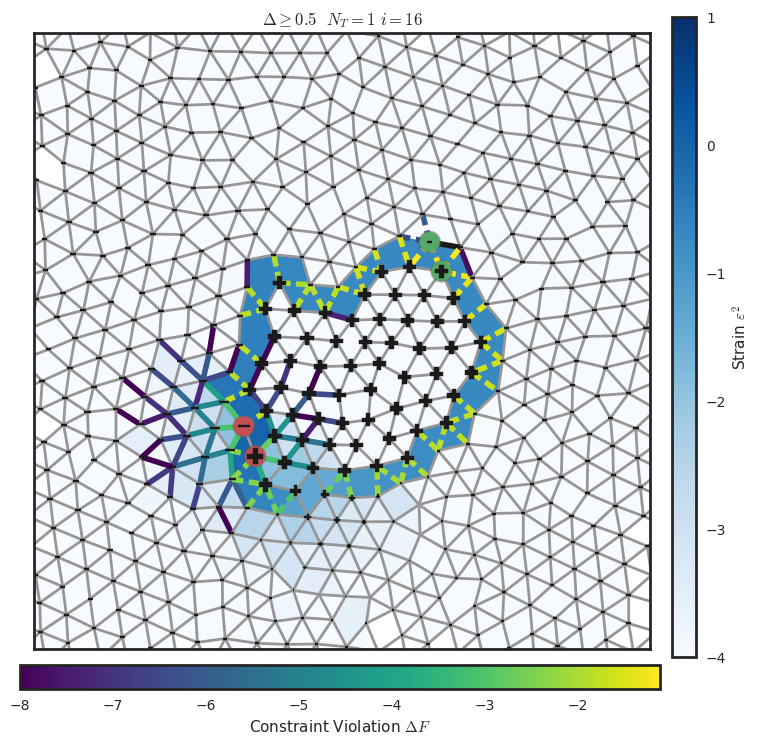

In [22]:
disp = data['disp']


facets = nutil.get_facets_2D(net2D)



fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1, 1, 1, aspect=1.0)



max_ext = nutil.calc_max_ext(net, facets, disp)
    
norm1 = mcolors.Normalize(vmin=-4, vmax=1)
cmap1 = mpl.cm.Blues
smap = mpl.cm.ScalarMappable(norm=norm1, cmap=cmap1)
  
    
styles = {fi: {} for fi in range(len(facets))}
for fi in range(len(facets)):
    styles[fi]['color'] = smap.to_rgba(np.log(max_ext[fi]))
        
        
nplot.show_facets(ax1, net2D, facets, styles=styles)

styles = {edge: {} for edge in range(net.NE)}
for edge in removed:
    styles[edge]['ls'] = (0.0, (2.0,1.0))

for edge in zm_edges:
    styles[edge]['color'] = 'k'
    styles[edge]['lw'] = 4.0

# print(np.min(cviol_obj), np.max(cviol_obj))
    
norm2 = mcolors.Normalize(vmin=-8, vmax=np.max(np.log10(cviol_obj)))
cmap2 = mpl.cm.viridis
smap = mpl.cm.ScalarMappable(norm=norm2, cmap=cmap2)

    
for edge in cviol_edges:
    styles[edge]['lw'] = 4.0
    styles[edge]['color'] = smap.to_rgba(np.log10(cviol_obj[edge]))
#     styles[edge]['color'] = 'r'
    
nplot.show_network(ax1, net2D, styles=styles, alpha = 1.0)
    
    

styles = {}
for i in inodesi:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj:
    styles[i] = {}
    styles[i]['color'] = 'r'
    

for i in onodesi:
    styles[i] = {}
    styles[i]['color'] = 'g'
for i in onodesj:
    styles[i] = {}
    styles[i]['color'] = 'g'

nplot.show_nodes(ax1, net2D, styles.keys(), styles=styles, marker='o', shadow=True)

styles = {}
for node in range(net.NN):
    
    if disp[node] < 0.0:
        styles[node] = {}
        styles[node]['size'] = 200*np.abs(disp[node])
        
nplot.show_nodes(ax1, net2D, styles.keys(), styles=styles, marker='_')

styles = {}
for node in range(net.NN):
    
    if disp[node] > 0.0:
        styles[node] = {}
        styles[node]['size'] = 200*np.abs(disp[node])
        
nplot.show_nodes(ax1, net2D, styles.keys(), styles=styles, marker='P')

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

ax1.set_title(r'$\Delta \geq {0}$  $N_T = {1}$ $i={2}$'.format(Delta, NTS, irec))

cax = fig.add_axes([0.925, 0.10, 0.03, 0.80])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap1,
                                norm=norm1,
                                orientation='vertical')

cbar.set_label(r"Strain $\varepsilon^2$")

cax = fig.add_axes([0.11, 0.06, 0.80, 0.03])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap2,
                                norm=norm2,
                                orientation='horizontal')

cbar.set_label(r"Constraint Violation $\Delta F$")

plt.show()

In [28]:
facets = nutil.get_facets_2D(net2D)
max_ext = nutil.calc_max_ext(net, facets, disp)

boundary_matrix = phat.boundary_matrix(representation = phat.representations.vector_vector)

columns = []
nodes_to_cols = {}
edges_to_cols = {}
for i in np.argsort(max_ext):
    
    for ni in facets[i]['nodes']:
        if nodes_to_cols
        columns.append((0, []))



boundary_matrix.columns = [ (0, []),
                            (0, []),
                            (1, [0,1]),
                            (0, []),
                            (1, [1,3]),
                            (1, [0,3]),
                            (2, [2,4,5])]

print("\nThe boundary matrix has %d columns:" % len(boundary_matrix.columns))
for col in boundary_matrix.columns:
    s = "Column %d represents a cell of dimension %d." % (col.index, col.dimension)
    if (col.boundary):
        s = s + " Its boundary consists of the cells " + " ".join([str(c) for c in col.boundary])
    print(s)
print("Overall, the boundary matrix has %d entries." % len(boundary_matrix))

pairs = boundary_matrix.compute_persistence_pairs()

pairs.sort()

print("\nThere are %d persistence pairs: " % len(pairs))
for pair in pairs:
    print("Birth: %d, Death: %d" % pair)

Number Facets: 892
[{'nodes': array([505, 509, 196]), 'edges': [771, 755, 754]}, {'nodes': array([ 94, 276, 318]), 'edges': [467, 486, 468]}, {'nodes': array([118, 142, 391]), 'edges': [220, 229, 223]}, {'nodes': array([190, 246, 309]), 'edges': [988, 999, 989]}, {'nodes': array([302, 122, 319]), 'edges': [1268, 1270, 686]}, {'nodes': array([163, 464,  88]), 'edges': [1204, 1301, 1173]}, {'nodes': array([351, 321, 247, 133]), 'edges': [803, 796, 789, 791]}, {'nodes': array([ 26, 399, 115, 169]), 'edges': [125, 128, 127, 122]}, {'nodes': array([481, 290, 122, 480]), 'edges': [713, 701, 703, 727]}, {'nodes': array([177, 252, 251]), 'edges': [432, 441, 431]}, {'nodes': array([251,  85, 108, 129]), 'edges': [415, 414, 419, 423]}, {'nodes': array([433, 391, 271]), 'edges': [246, 237, 239]}, {'nodes': array([421, 430, 350]), 'edges': [1220, 1218, 721]}, {'nodes': array([259,  31, 237]), 'edges': [935, 1358, 1360]}, {'nodes': array([  8, 456,  51, 436]), 'edges': [170, 175, 174, 169]}, {'node